# 🔥 TensorNet Demo

A complete tensor network library in pure PyTorch.

In [1]:
# Clone the repo (run once in Colab)
!rm -rf PyTenNet  # Force fresh clone
!git clone https://github.com/tigantic/PyTenNet.git
import sys
sys.path.insert(0, 'PyTenNet')

Cloning into 'PyTenNet'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 102 (delta 33), reused 90 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (102/102), 50.14 KiB | 3.58 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [2]:
import torch
import math
from tensornet import (
    MPS, heisenberg_mpo, tfim_mpo,
    ghz_mps, dmrg, svd_truncated
)

print(f"PyTorch: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch: 2.9.0+cpu
Device: cpu


## 1. MPS Round-Trip

In [3]:
torch.manual_seed(42)
tensor = torch.randn(2, 2, 2, 2, 2, dtype=torch.float64)
mps = MPS.from_tensor(tensor, chi_max=8)
reconstructed = mps.to_tensor()
error = (tensor - reconstructed).norm().item()
print(f"Reconstruction error: {error:.2e}")

Reconstruction error: 8.74e-15


## 2. GHZ Entanglement

In [4]:
ghz = ghz_mps(L=6)
for bond in range(5):
    S = ghz.entropy(bond)
    print(f"Bond {bond}: S = {S:.6f} (exact: {math.log(2):.6f})")

Bond 0: S = 0.693147 (exact: 0.693147)
Bond 1: S = 0.693147 (exact: 0.693147)
Bond 2: S = 0.693147 (exact: 0.693147)
Bond 3: S = 0.693147 (exact: 0.693147)
Bond 4: S = 0.693147 (exact: 0.693147)


## 3. DMRG Ground State

In [5]:
L = 10
H = heisenberg_mpo(L=L, J=1.0)
psi = MPS.random(L=L, d=2, chi=32)

psi, E, info = dmrg(psi, H, num_sweeps=10, chi_max=32)
print(f"Ground state energy: {E:.8f}")
print(f"Energy per site: {E/L:.8f}")
print(f"Converged in {info['num_sweeps']} sweeps")

Ground state energy: -4.25803521
Energy per site: -0.42580352
Converged in 2 sweeps


## 4. Quantum Phase Transition

g=0.2: E/L = -0.928367
g=0.5: E/L = -0.991004
g=0.8: E/L = -1.115961
g=1.0: E/L = -1.243831
g=1.2: E/L = -1.398878
g=1.5: E/L = -1.656592
g=2.0: E/L = -2.116125


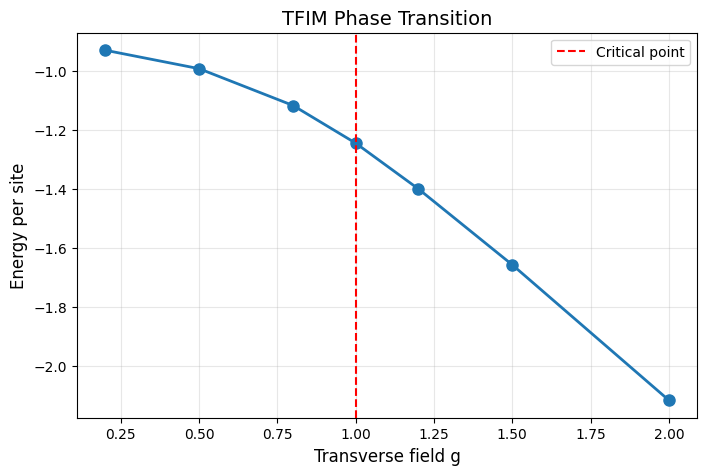

In [6]:
import matplotlib.pyplot as plt

L = 12
g_values = [0.2, 0.5, 0.8, 1.0, 1.2, 1.5, 2.0]
energies = []

for g in g_values:
    H = tfim_mpo(L=L, J=1.0, g=g)
    psi = MPS.random(L=L, d=2, chi=32)
    psi, E, _ = dmrg(psi, H, num_sweeps=10, chi_max=32)
    energies.append(E/L)
    print(f"g={g:.1f}: E/L = {E/L:.6f}")

plt.figure(figsize=(8, 5))
plt.plot(g_values, energies, 'o-', linewidth=2, markersize=8)
plt.axvline(x=1.0, color='red', linestyle='--', label='Critical point')
plt.xlabel('Transverse field g', fontsize=12)
plt.ylabel('Energy per site', fontsize=12)
plt.title('TFIM Phase Transition', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Entanglement Entropy Profile

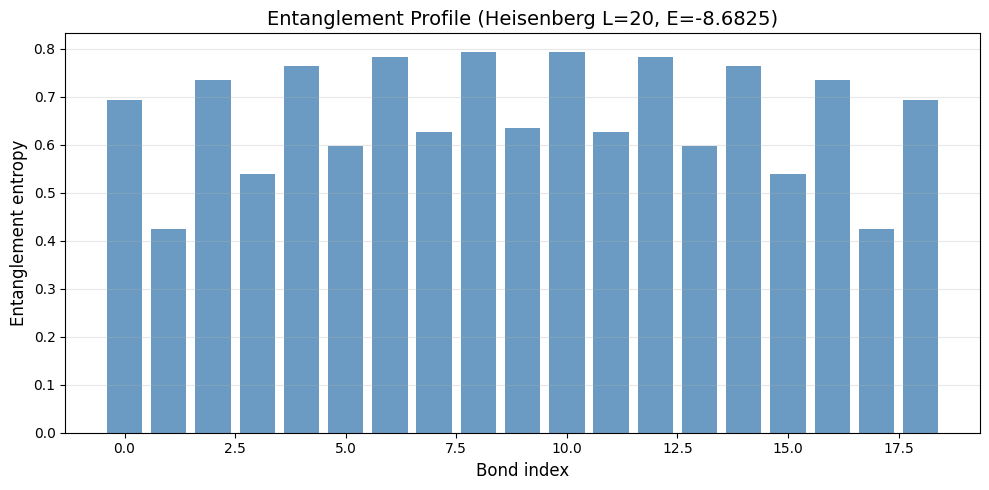

Max entropy at center: 0.7924


In [7]:
# Entanglement entropy across bonds for Heisenberg ground state
L = 20
H = heisenberg_mpo(L=L, J=1.0)
psi = MPS.random(L=L, d=2, chi=64)
psi, E, _ = dmrg(psi, H, num_sweeps=15, chi_max=64)

entropies = [psi.entropy(bond) for bond in range(L-1)]

plt.figure(figsize=(10, 5))
plt.bar(range(L-1), [s.item() for s in entropies], color='steelblue', alpha=0.8)
plt.xlabel('Bond index', fontsize=12)
plt.ylabel('Entanglement entropy', fontsize=12)
plt.title(f'Entanglement Profile (Heisenberg L={L}, E={E:.4f})', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f'Max entropy at center: {max(entropies):.4f}')

## 6. DMRG Convergence

Sweep  1: E = -6.9117371456
Sweep  2: E = -6.9117371456
Sweep  3: E = -6.9117371456
Sweep  4: E = -6.9117371456
Sweep  5: E = -6.9117371456
Sweep 10: E = -6.9117371456
Sweep 15: E = -6.9117371456
Sweep 20: E = -6.9117371456


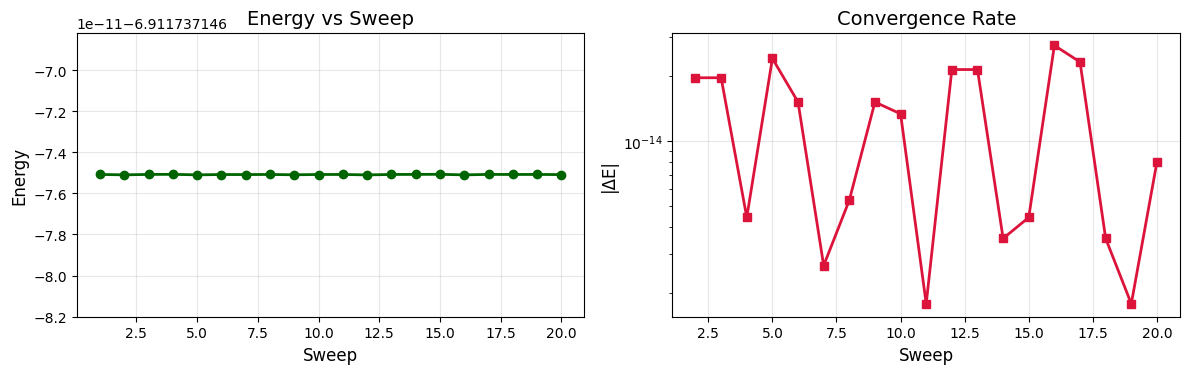

In [8]:
# Track energy convergence during DMRG sweeps
L = 16
H = heisenberg_mpo(L=L, J=1.0)
psi = MPS.random(L=L, d=2, chi=64)

energy_history = []
for sweep in range(1, 21):
    psi, E, _ = dmrg(psi, H, num_sweeps=1, chi_max=64)
    energy_history.append(E)
    if sweep <= 5 or sweep % 5 == 0:
        print(f'Sweep {sweep:2d}: E = {E:.10f}')

# Plot convergence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(range(1, 21), energy_history, 'o-', color='darkgreen', linewidth=2)
ax1.set_xlabel('Sweep', fontsize=12)
ax1.set_ylabel('Energy', fontsize=12)
ax1.set_title('Energy vs Sweep', fontsize=14)
ax1.grid(True, alpha=0.3)

# Energy change (log scale)
dE = [abs(energy_history[i] - energy_history[i-1]) for i in range(1, len(energy_history))]
ax2.semilogy(range(2, 21), dE, 's-', color='crimson', linewidth=2)
ax2.set_xlabel('Sweep', fontsize=12)
ax2.set_ylabel('|ΔE|', fontsize=12)
ax2.set_title('Convergence Rate', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()